
# <center>Convolutional Neural Network for Image Recognition</center>
### <center>Calvin Chi</center>

<div class="cite2c-biblio"></div>

# 1. Introduction

This notebook is largely based on the paper [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) [1] for method and this [blog post](https://medium.com/@joeyism/creating-alexnet-on-tensorflow-from-scratch-part-2-creating-alexnet-e0cd948d7b04) for Tensorflow implementation. The purpose is to list out tips presented in this paper and to provide an approximate implementation of the method for didatic purposes.

+ Learned feature detectors are referred to as kernels, and the resulting activations produced from running a kernel over input activation layers are collectively referred to as a kernel map.
+ Overlapping pooling reported to mitigate overfitting.
+ Since producing a kernel map is an independent process for each kernel, these steps are parallelized over GPUs. 
+ Dropout roughly doubles the number of iterations required to converge.

# 2. Data Preparation

A smaller dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) [2] will be used instead of ImageNet. Briefly, the CIFAR-10 dataset contains 50,000 training images and 10,000 test images acrosss 10 classes. 

In [6]:
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np
import math
%matplotlib inline

def __extract_file__(fname):
    with open(fname, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d

def __unflatten_image__(img_flat):
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    return img
  
def extract_reshape_file(fname):
    res = []
    d = __extract_file__(fname)
    unflatted_images = []
    images, labels = d[b"data"], d[b"labels"]
    for i in range(len(images)):
        unflatted_images.append(__unflatten_image__(images[i]))
    return unflatted_images, labels

def get_images_from_cifar(dir, findex = [1, 2, 3, 4]):
    files = []
    for index in findex:
        files.append("data_batch_" + str(index))
    images, labels = [], []
    for f in files:
        image_batch, label_batch = extract_reshape_file(os.path.join(dir, f))
        images = images + image_batch
        labels = labels + label_batch
    return [np.array(images), np.array(labels)]

Use 40,000 samples for train, 10,000 samples for validation, and 10,000 samples for test.

In [7]:
Xtrain, Ytrain = get_images_from_cifar("data/cifar-10-batches-py/")
Xvalid, Yvalid = get_images_from_cifar("data/cifar-10-batches-py/", findex=[5])
Xtest, Ytest = extract_reshape_file("data/cifar-10-batches-py/test_batch")
Xtest = np.array(Xtest)
Ytest = np.array(Ytest)

Load the dataset and metadata that maps class index to class name.

In [8]:
with open("data/cifar-10-batches-py/batches.meta", 'rb') as fo:
    meta_data = pickle.load(fo, encoding='bytes')
    
# example: class name of index 0
print(meta_data[b"label_names"][0])

b'airplane'


Plot a few randomly selected images.

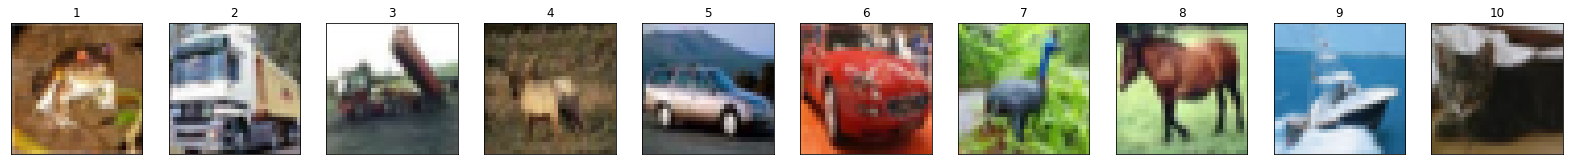

In [9]:
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(i + 1)
        plt.xticks(())
        plt.yticks(())

images = Xtrain[:10, :, :, :]
h, w, c = images[0].shape
        
plot_portraits(images, h, w, n_row=1, n_col=10)

In Krizhevsky _et al_., data augmentation was performed by altering RGB channel intensities of training images. Specifically, each training image $X \in \mathbb{R}^{32 \times 32 \times 3}$ is re-arranged into $\tilde{X} \in \mathbb{R}^{1024 \times 3}$, and PCA is applied to retrieve eigenvectors $p_1, p_2, p_3 \in \mathbb{R}^{3}$ and eigenvalues $\lambda_1, \lambda_2, \lambda_3$, which are the eigenvectors and eigenvalues of covariance matrix $C \in \mathbb{R}^{3 \times 3}$ from $\tilde{X}$. Each RGB image pixel $I_{xy} = [I_{xy}^{R}, I_{xy}^{G}, I_{xy}^{B}]^{\top}$ is then altered with addition of 

$$
\left[
  \begin{array}{ccc}
    \mid & \mid & \mid\\
    p_{1}  & p_{2}  & a_{3}\\
    \mid & \mid & \mid
  \end{array}
\right]
\begin{bmatrix}
\alpha_1\lambda_1\\
\alpha_2\lambda_2\\
\alpha_3\lambda_3\\
\end{bmatrix}
$$

where $\alpha_{i} \stackrel{i.i.d.}{\sim} \mathcal{N}(0, 0.1)$, which is redrawn once and applied to every pixel each time an image is encountered during training. Intuitively, this corresponds to adding to an image a noisy weighted linear combination of RGB pixel intensity bases. First perform PCA.

In [306]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sample_image = Xtrain[0].reshape(32 * 32, 3) 

# perform PCA
pca = PCA(n_components=3)
scaler = StandardScaler()
pca.fit(scaler.fit_transform(sample_image))

eigenvectors = pca.components_
eigenvalues = pca.explained_variance_

Generate perturbation to add to each pixel. To illustrate the visual effect, the standard deviation is purposely set to 5. In practice the standard deviation is set to 0.1 since the purpose is to train the convolutional neural network (CNN) to be robust to small perturbations of the same image. 

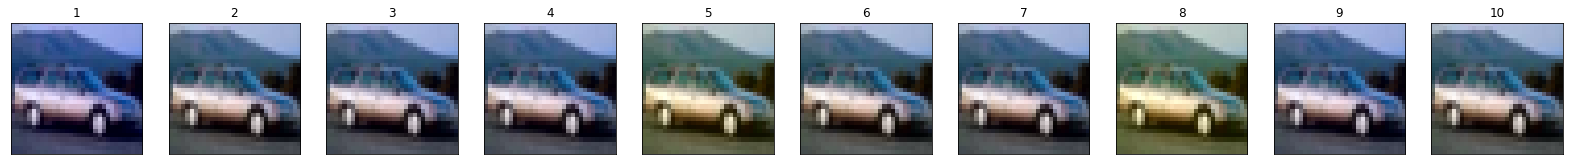

In [309]:
def generate_noise(eigenvectors, eigenvalues, std = 0.1):
    # create noise
    alpha_lambda = np.random.normal(0, std, (3)) * eigvenvalues
    perturbation = eigenvectors.dot(alpha_lambda)
    perturbation = np.tile(perturbation, (32, 32, 1))
    return perturbation

images = []
for i in range(10):
    perturbation = generate_noise(eigenvectors, eigenvalues, std = 5)
    perturbed_image = Xtrain[4] + perturbation
    perturbed_image = np.maximum(perturbed_image, np.zeros((32, 32, 3)))
    perturbed_image = np.minimum(perturbed_image, 255 * np.ones((32, 32, 3)))
    perturbed_image = perturbed_image / 255.0
    images.append(perturbed_image)
    
plot_portraits(images, h, w, n_row=1, n_col=10)

Since pixel values range from 0 to 255, rescale them to range from 0 to 1 to "shift" the input values to overlap with the more non-linear portions of the non-linearity functions used in the model.

In [10]:
Xtrain = Xtrain / 255.0
Xvalid = Xvalid / 255.0
Xtest = Xtest / 255.0

# 3. Implementation

The CNN to be implemented is based off of AlexNet. We will use Tensorflow version 2.1.0. A few selected aspects of the CNN are discussed.

+ Over a mini-batch of $m$ samples across $k$ classes, the loss to be minimized is the average cross entropy. Here $p^{(i)} \in \mathbb{R}^{k}$ is the true label one-hot encoding for $i$-th sample and $q^{(i)} \in \mathbb{R}^{k}$ is the predicted class probability distribution over $k$ classes. 

$$H(p, q) = -\frac{1}{m}\sum_{i = 1}^{m}\sum_{j = 1}^{k}p_{j}^{(i)}\log q_{j}^{(i)}$$

+ The probability that label $y$ belongs to $j$-th class is

$$\mathbb{P}(y = j) = q_{j} = \frac{e^{z_{j}}}{\sum_{i =1}^{k}e^{z_{i}}}$$

+ For above, $z \in \mathbb{R}^{k}$ is termed the logit, from the relationship $\ln\left(\frac{p}{1 - p}\right) = z$. The $z$ is the last output of the neural network without applying non-linearity.

Below is implementation in Tensorflow.

In [25]:
import tensorflow as tf

class AletNetSmall(object):
    
    def __init__(self, sess, learning_rate = 0.001, img_dim = 32, batch_size = 128):
        super(AletNetSmall, self).__init__()
        self.image_dim = img_dim
        self.sess = sess
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.__build_computational_graph__()
        self.__define_train_ops__()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        self.checkpoint_dir = "checkpoints/"
        
    def __define_train_ops__(self):
        self.label_ph = tf.compat.v1.placeholder(tf.compat.v1.int64, shape = [None,], 
                                                 name = "labels")
        label_onehot = tf.one_hot(self.label_ph, depth = 10)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logit, 
                                                                      labels = label_onehot))
        self.opt = tf.compat.v1.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.loss)
        
        
    def __conv_layer__(self, inputs, filters, kernel_size, input_dim, stride, scope_name, 
                       simple=False):
        with tf.compat.v1.variable_scope(scope_name):
            kernel = tf.compat.v1.get_variable(initializer = tf.initializers.he_normal(),
                                               shape = [kernel_size, kernel_size, input_dim, filters],
                                               name = "kernel")
            conv = tf.nn.conv2d(inputs, filters = kernel, strides = stride, 
                                padding = "SAME")
            bias = tf.compat.v1.get_variable(initializer=tf.constant_initializer(1),
                                            shape = [filters], name = "bias")
            conv_with_bias = tf.nn.bias_add(conv, bias)
            conv_nonlinear = tf.compat.v1.nn.relu(conv_with_bias)
            if not simple:
                lrn = tf.nn.local_response_normalization(conv_nonlinear, alpha = 1e-4, beta = 0.75, 
                                                         bias = 2.0, depth_radius = 2)
                pool = tf.nn.max_pool(lrn, ksize = [3, 3], strides = [2, 2], padding = "SAME")
                return pool
            else:
                return conv_nonlinear
        
    def __build_computational_graph__(self):
        self.input_ph = tf.compat.v1.placeholder(tf.compat.v1.float32, 
                                                 shape = [None, 32, 32, 3],
                                                 name = "input_images")

        # convolutional layers
        conv1 = self.__conv_layer__(self.input_ph, filters = 48, kernel_size = 7, input_dim = 3, stride = 2,
                               scope_name = "conv1")
        conv2 = self.__conv_layer__(conv1, filters = 128, kernel_size = 5, input_dim = 48, stride = 1,
                              scope_name = "conv2")
        conv3 = self.__conv_layer__(conv2, filters = 192, kernel_size = 3, input_dim = 128, stride = 1,
                              scope_name = "conv3", simple = True)
        conv4 = self.__conv_layer__(conv3, filters = 192, kernel_size = 3, input_dim = 192, stride = 1,
                              scope_name = "conv4", simple = True)
        conv5 = self.__conv_layer__(conv4, filters = 192, kernel_size = 3, input_dim = 192, stride = 1,
                              scope_name = "conv5", simple = True)

        # fully-connected layers
        conv5_flatten = tf.keras.layers.Flatten()(conv5)
        fc1 = tf.keras.layers.Dense(units = 512, activation = "relu", use_bias=True, 
                                    kernel_initializer='he_normal', 
                                    bias_initializer='ones')(conv5_flatten)
        fc1_dropout = tf.nn.dropout(x = fc1, rate = 0.5)
        
        fc2 = tf.keras.layers.Dense(units = 512, activation = "relu", use_bias=True, 
                                    kernel_initializer='he_normal', 
                                    bias_initializer='ones')(fc1_dropout)
        fc2_dropout = tf.nn.dropout(x = fc2, rate = 0.5)
        
        logit = tf.keras.layers.Dense(units = 10, use_bias=True, 
                                      kernel_initializer='he_normal',
                                      bias_initializer='ones')(fc2)
        self.logit = logit
                                        
    def train(self, Xtrain, Ytrain, Xvalid, Yvalid, verbose = True, epochs = 50):
        saver = tf.compat.v1.train.Saver()
        for epoch in range(epochs):
            for i in range(math.ceil(len(Xtrain) / self.batch_size)):
                Xbatch = Xtrain[i * self.batch_size:(i + 1) * self.batch_size]
                Ybatch = Ytrain[i * self.batch_size:(i + 1) * self.batch_size]
                _, loss_batch = self.sess.run([self.opt, self.loss], 
                                              feed_dict={self.input_ph: Xbatch, 
                                                         self.label_ph: Ybatch})
                if verbose and i % 100 == 0:
                    class_pred = self.predict_class(Xvalid)
                    accuracy = np.mean(class_pred == Yvalid)
                    print('mean cross entropy: {:.3f} | validation accuracy: {:.3f}'.format(loss_batch, 
                                                                                            accuracy))
            if epoch % 5 == 0:
                saver.save(sess, save_path='models/AlexNetSmall.ckpt')
            
            # shuffle training dataset with each epoch for more randomless in gradients
            shuffle_idx = np.random.permutation(len(Xtrain))
            Xtrain = Xtrain[shuffle_idx]
            Ytrain = Ytrain[shuffle_idx]
            
    def predict(self, X):
        softmax = tf.nn.softmax(self.logit)
        return self.sess.run(softmax, feed_dict={self.input_ph: X})
    
    def predict_class(self, X):
        probs = self.predict(X)
        return np.argmax(probs, axis = 1)

## 3.1 Training

Initialize model and train for 10 epochs over training dataset for demonstration (model has already been trained for many epochs before).

In [27]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()
model = AletNetSmall(sess)

model.train(Xtrain, Ytrain, Xvalid, Yvalid, epochs = 10)

mean cross entropy: 0.116 | validation accuracy: 0.650
mean cross entropy: 0.121 | validation accuracy: 0.644
mean cross entropy: 0.093 | validation accuracy: 0.648
mean cross entropy: 0.051 | validation accuracy: 0.647
mean cross entropy: 0.306 | validation accuracy: 0.649
mean cross entropy: 0.215 | validation accuracy: 0.656
mean cross entropy: 0.165 | validation accuracy: 0.655
mean cross entropy: 0.362 | validation accuracy: 0.650
mean cross entropy: 0.086 | validation accuracy: 0.650
mean cross entropy: 0.097 | validation accuracy: 0.658
mean cross entropy: 0.137 | validation accuracy: 0.654
mean cross entropy: 0.304 | validation accuracy: 0.665
mean cross entropy: 0.069 | validation accuracy: 0.656
mean cross entropy: 0.118 | validation accuracy: 0.659
mean cross entropy: 0.080 | validation accuracy: 0.665
mean cross entropy: 0.161 | validation accuracy: 0.659
mean cross entropy: 0.126 | validation accuracy: 0.655
mean cross entropy: 0.020 | validation accuracy: 0.659
mean cross

## 3.2 Testing

Load the saved model and evaluate performance on test dataset.

In [28]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()

model = AletNetSmall(sess)
saver = tf.compat.v1.train.Saver()
saver.restore(sess, 'models/AlexNetSmall.ckpt')

pred_class = model.predict_class(Xtest)

print("test accuracy: {0}".format(np.mean(pred_class == Ytest)))

INFO:tensorflow:Restoring parameters from models/AlexNetSmall.ckpt
test accuracy: 0.6436


Plot confusion matrix.

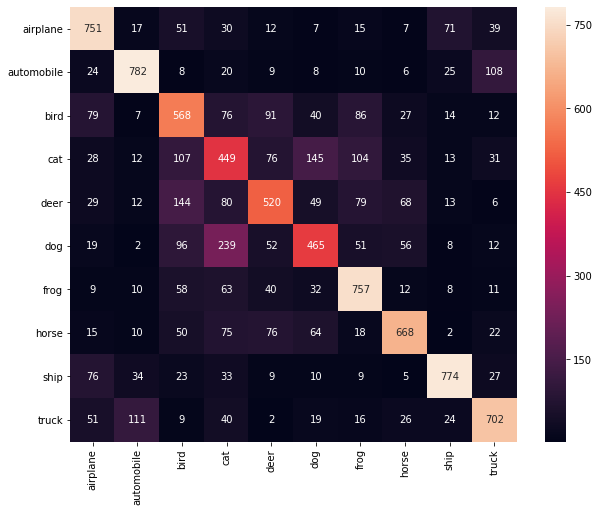

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

confusion_matix = confusion_matrix(Ytest, pred_class)
class_names = [s.decode("utf-8") for s in meta_data[b'label_names']]
df_cm = pd.DataFrame(confusion_matix, index = class_names, columns=class_names)
plt.figure(figsize=(10, 8))
sn.heatmap(df_cm, annot = True, fmt='d')

# 4. Kernel Visualization

It has been reported by Krizhevsky _et_ _al_. that some kernels become orientation-selective or color-selective kernels. Visualize some kernel weights to see evidence of this.

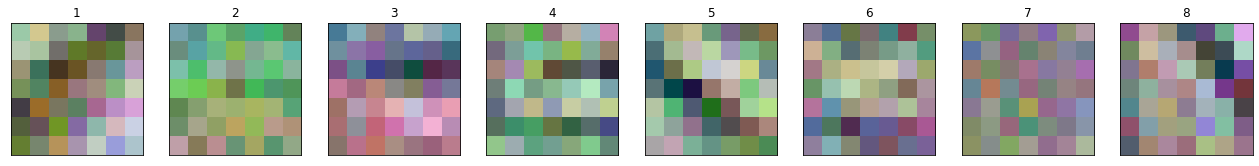

In [60]:
current_graph = tf.compat.v1.get_default_graph()
all_names = [op.name for op in current_graph.get_operations()]

kernels1 = [var for var in tf.compat.v1.trainable_variables('conv1') if var.name == 'conv1/kernel:0'][0]
run_kernels1 = sess.run(kernels1)
run_kernels1 = np.transpose(run_kernels1, (3, 0, 1, 2))
run_kernels1 = (run_kernels1 - np.min(run_kernels1)) / (np.max(run_kernels1) - np.min(run_kernels1))
kernels_select1 = [run_kernels1[i] for i in range(len(run_kernels1)) if i in [0, 4, 7, 13, 14, 34, 35, 44]]
plot_portraits(run_kernels1, 7, 7, 1, 8)

# References

1. A. Krizhevsky, I. Sutskever, and G. E. Hinton, "Imagenet classification with deep convolutional neural networks," in Advances in neural information processing systems, pp. 1097-1105, 2012.
2. Krizhevsky, Alex, and Geoffrey Hinton. "Learning multiple layers of features from tiny images." (2009): 7.